# Sentiment Analysis 

In [1]:
from __future__ import print_function
import sys
import csv
import numpy as np
from numpy import exp, array, random, dot
import pandas as pd
import nltk
import spacy
import tensorflow as tf
import sklearn
import en_core_web_sm
import vaderSentiment
from gensim.models import KeyedVectors
import keras
from keras import layers
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from IPython import display
from keras.preprocessing.sequence import pad_sequences 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import numpy as np
import fastText
sid = SentimentIntensityAnalyzer()

Using TensorFlow backend.


The identification of sentiment in text is an important field of study, it usually involves detecting whether a piece of text expresses a POSITIVE, a NEGATIVE, or a NEUTRAL sentiment; the sentiment can be general or about a specific topic, e.g., a person, a product, or an event.

Sentiment analysis has been part of the international workshop on Semantic Evaluation ([SemEval](https://en.wikipedia.org/wiki/SemEval)) for multiple years ([2016](http://anthology.aclweb.org/S/S16/S16-1001.pdf), [2017](http://www.aclweb.org/anthology/S17-2088)).

You task is to implement a neural network that predicts sentiment (POSITIVE, NEGATIVE, NEUTRAL) for a given text.

In the following sections, we provide the dataset preperation, a basic model, training and evaluation.


## Dataset

The dataset we are using to train and test our model is generated from German Amazon reviews.

The input is the text of the review, and the network will try to predict the star ratings.

We include only reviews with 1,3 and 5 star ratings, where: 
* 1 is considered negative
* 3 is considered neutral
* 5 is considered positive

All reviews with rating 2,4 are not included in our dataset.


### Loading the data

We already created a python script that returns amazon reviews whose star ratings are either 1,3 or 5.

In [ ]:
#DON'T NEED TO RUN EVERYTIME
dfTest =pd.read_csv("tweetTrainingContext.csv", header=None)
dfTest.drop(0, axis=1, inplace=True)
dfTest = dfTest[dfTest[2] != 1]
dfTest = dfTest[dfTest[2] != -1]
dfTest.loc[dfTest[2] == 2, 2] = 5
dfTest.loc[dfTest[2] == -2, 2] = 1
dfTest.loc[dfTest[2] == 0, 2] = 3
#dfTest[2].sample(n=43, replace=True, random_state=1)
print (Counter(dfTest[2]))
dfTest.columns=['subject','label','body']
dfTest.to_csv("tweetTrainingContextFilter.csv")

In [2]:
#LOAD TRAINING DATA
#{3: 2912, 5: 638, 1: 161})
dfTrain = pd.read_csv("tweetTrainingContextFilter.csv")


In [4]:
#dfTrain
dfTrain

,Unnamed: 0,subject,label,body
0,1,sony,3,"@PersonaSoda well yeah, that's third parties. ..."
1,6,sony,3,Sony's 1st teaser package for the launch of th...
2,7,sony,3,#tv Ind vs SL 3rd Test Day 3: Cricket live sco...
3,8,sony,3,@TruthInsider @bertymufc @gamerxone720 @PNF4LY...
4,9,sony,3,"@greencapt Official reason, because the game h..."
5,12,sony,3,I know it's coming coon but I don't get why it...
6,15,sony,3,At least Sony will probably be selling it for ...
7,16,sony,3,@InnoBystander Might keep SONY monthly subs go...
8,18,sony,3,Uncharted 4: A Thief's End launches for PS4 in...
9,21,sony,3,"@Adam_OliverYT Hi Adam, you may need to contac..."


The number of reviews is originally not equally distributed among the ratings, so we downsampled the reviews so that there is the same number for each rating. The discarded reviews are picked at random.

Counter({3: 675, 5: 53, 1: 43})

#### Examples

Printing out some data examples:

NameError: name 'free' is not defined

### Word Embeddings and Features

To convert text to vector space, we use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) where words from the vocabulary are mapped to vectors of real numbers.

Multiple versions of the word embeddings have already been implemented, we use Facebook's [FastText](https://research.fb.com/fasttext/) library.

We trained our word embeddings on German wikipedia.

In [3]:
#RUN THIS: Load Models
twitterModel = KeyedVectors.load("twitterModel_1000000")
wikiModel = KeyedVectors.load("wikiModel")

Loading the Fasttext model (the following code might take some time to run, because the model is big)

In [5]:
#Don't have to run now
#Creates model with word relationship given a vectors of tokenized sentances. Example: determines "car" is like "automobile"
#basically creates model that understands human language based on input
#takes maybe 15 min to run
#vector i'm training on has a series of 300 token sentences/paragraphs
en_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")

#en_model.save("wikiModel")

In [17]:
#DON'T BOTHER RUNNING
#Prove model is loaded
words = []

for word in wikiModel.vocab:

    words.append(word)

In [18]:
#DON'T BOTHER RUNNING
#number of words in vector
print("Number of Tokens: {}".format(len(words)))

Number of Tokens: 999994


In [19]:
#DON'T BOTHER RUNNING
# Printing out the dimension of a word vector 

print("Dimension of a word vector: {}".format(

    len(wikiModel[words[0]])

))

Dimension of a word vector: 300


In [20]:
#DON'T BOTHER RUNNING
# Print out the vector of a word 

print("Vector components of a word: {}".format(

    wikiModel[words[0]]

))

Vector components of a word: [ 1.0730e-01  8.9000e-03  6.0000e-04  5.5000e-03 -6.4600e-02 -6.0000e-02
  4.5000e-02 -1.3300e-02 -3.5700e-02  4.3000e-02 -3.5600e-02 -3.2000e-03
  7.3000e-03 -1.0000e-04  2.5800e-02 -1.6600e-02  7.5000e-03  6.8600e-02
  3.9200e-02  7.5300e-02  1.1500e-02 -8.7000e-03  4.2100e-02  2.6500e-02
 -6.0100e-02  2.4200e-01  1.9900e-02 -7.3900e-02 -3.1000e-03 -2.6300e-02
 -6.2000e-03  1.6800e-02 -3.5700e-02 -2.4900e-02  1.9000e-02 -1.8400e-02
 -5.3700e-02  1.4200e-01  6.0000e-02  2.2600e-02 -3.8000e-03 -6.7500e-02
 -3.6000e-03 -8.0000e-03  5.7000e-02  2.0800e-02  2.2300e-02 -2.5600e-02
 -1.5300e-02  2.2000e-03 -4.8200e-02  1.3100e-02 -6.0160e-01 -8.8000e-03
  1.0600e-02  2.2900e-02  3.3600e-02  7.1000e-03  8.8700e-02  2.3700e-02
 -2.9000e-02 -4.0500e-02 -1.2500e-02  1.4700e-02  4.7500e-02  6.4700e-02
  4.7400e-02  1.9900e-02  4.0800e-02  3.2200e-02  3.6000e-03  3.5000e-02
 -7.2300e-02 -3.0500e-02  1.8400e-02 -2.6000e-03  2.4000e-02 -1.6000e-02
 -3.0800e-02  4.3400e-

In [7]:
#DON'T BOTHER RUNNING
# Finding out similar words [default= top 10]
find_similar_to = 'Clinton'
for similar_word in wikiModel.similar_by_word(find_similar_to):

    print("Word: {0}, Similarity: {1:.2f}".format(

        similar_word[0], similar_word[1]

    ))
for similar_word in twitterModel.similar_by_word(find_similar_to):

    print("Word: {0}, Similarity: {1:.2f}".format(

        similar_word[0], similar_word[1]

    ))



Word: Hillary, Similarity: 0.78
Word: Clintons, Similarity: 0.70
Word: Cinton, Similarity: 0.69
Word: Bush, Similarity: 0.69
Word: Hiliary, Similarity: 0.69
Word: Clinton-, Similarity: 0.68
Word: CLinton, Similarity: 0.67
Word: Obama, Similarity: 0.65
Word: clinton, Similarity: 0.64
Word: Clinto, Similarity: 0.64


c:\users\jowo\onedrive - microsoft\john_woods\projects\ml capstone\pytest\env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()


Word: clinton, Similarity: 0.46
Word: HRC, Similarity: 0.41
Word: She, Similarity: 0.39
Word: Trump, Similarity: 0.38
Word: she, Similarity: 0.38
Word: HillaryClinton, Similarity: 0.37
Word: her, Similarity: 0.36
Word: Bernie, Similarity: 0.34
Word: Tim, Similarity: 0.34
Word: the, Similarity: 0.31


### Question 1

What other word embedding models can we use and what are the advantages of using Fasttext?

Please write your answer in the next cell:

Next, we convert all text in the dataset into sequences of word indices. A "word index" would simply be an integer ID for the word. We will truncate the sequences to a maximum length of 200 words.
If sequences are shorter than 100, then we need to pad them with zeros

In [77]:
MAX_SEQUENCE_LENGTH = 100
#EMBEDDING_DIM = wikiModel.dim
EMBEDDING_DIM = 300

In [78]:
print(EMBEDDING_DIM)

300


In [79]:
from keras.preprocessing.sequence import pad_sequences 

vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in dfTrain.body:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

18959 unique tokens in the vocabulary


In [80]:
print(dfTrain.body[:2])

0    @PersonaSoda well yeah, that's third parties. ...
1    Sony's 1st teaser package for the launch of th...
Name: body, dtype: object


In [81]:
import re
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " .", text)
    text = re.sub(r"\!", " !", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r"\,", " ,", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"ohh", "oh", text)
    text = re.sub(r"ohhh", "oh", text)
    text = re.sub(r"ohhhh", "oh", text)
    text = re.sub(r"ohhhhh", "oh", text)
    text = re.sub(r"ohhhhhh", "oh", text)
    text = re.sub(r"ahh", "ah", text)
    
    return text

In [82]:
bodies2 = []
for line in dfTrain.body:
    bodies2.append(clean_text(line))

In [83]:
bodies=bodies2

In [84]:


vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

13792 unique tokens in the vocabulary


In [85]:
#INdex of words padded to 200 words
print(bodies_seq[:2])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3
   4  5  6  7  8  9 10 11  6 12 13 14 15 16 17 18  9 18  6 19 20 21 22 23
  24 25 26  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 27 28 29 30 17 31 32 22 31 33 34 35 36 37 38 39
  40 41 42 43]]


### Question 2

As you can see, there is a huge number of unique tokens extracted from the reviews. Can you think of any preprocessing steps to make the vocabulary smaller?

Edit the code block above to add more preprocessing steps.


### Splitting into Train/Val/Test Sets

Split the dataset into 3 sets: train, validation and test.

We use ```sklearn.model_selection.train_test_split``` twice. First to split to train, val and then split val again into val and test. 

In [86]:
from sklearn.model_selection import train_test_split

data = {
    'train': {},
    'val': {},
    'test': {},
}

(data['train']['text'],
 data['val']['text'],
 data['train']['y'],
 data['val']['y']
) = train_test_split(bodies_seq, dfTrain.label, test_size=0.1)

(data['val']['text'],
 data['test']['text'],
 data['val']['y'],
 data['test']['y']
) = train_test_split(data['val']['text'], data['val']['y'], test_size=0.1)

print('Train: {} examples'.format(len(data['train']['y'])))
print('Val: {} examples'.format(len(data['val']['y'])))
print('Test: {} examples'.format(len(data['test']['y'])))

Train: 3339 examples
Val: 334 examples
Test: 38 examples


## Neural Network

In [87]:
data['val']['y']

2599    3
2997    3
871     1
369     1
705     3
2460    3
970     3
1293    3
2384    3
3390    1
446     3
1754    3
538     3
1620    5
3344    5
3430    3
377     1
572     3
2684    3
3267    3
797     3
1852    3
316     3
3379    3
2855    5
1660    1
2475    3
786     3
855     3
3089    5
       ..
2703    3
282     3
3368    3
617     3
1860    3
1523    3
2600    3
3141    3
1640    1
277     3
5       3
3504    3
2707    5
1518    3
3260    3
3676    3
1266    3
1063    3
452     3
702     3
1115    3
2136    5
2764    3
891     3
1211    3
1580    5
3084    5
1739    3
3139    3
2168    3
Name: label, Length: 334, dtype: int64

### The Embedding layer

Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

In [88]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM)) 
for word, i in vocabulary.items():
    if word in wikiModel:
        embedding_matrix[i] = wikiModel[word]

### Question 3

How should we handle a word that is not found in the embeddings model (out of vocabulary words)?

Please write your answer in the next cell:

In [89]:
print(MAX_SEQUENCE_LENGTH)
print(EMBEDDING_DIM)

100
300


### Model Definition

In [96]:
class BaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)
            
        fc_layer = layers.Dense(
            units=100,
            name='FullyConnected'
        )(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(
            6,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [97]:
model = BaselineModel()
model.compile()

In [17]:
#JUST FOR VISUALIZING MODEL? DON'T NEED?
from graphviz import Digraph

display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

### Model Training

In [98]:
data['train']['y'].shape

(3339,)

In [99]:

history = model.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],0),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],0)
    ),
    batch_size=128
)

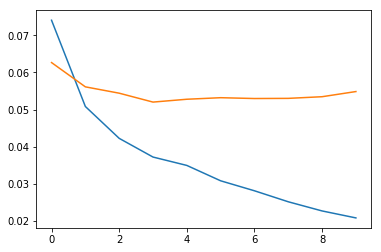

In [101]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
#Yellow=Validation set
#Blue= Training Set
#_=_

### Question 4

This model is very simple, it consists of only the embedding layer and one dense layer. By looking at the graph above, you can see that the model is not generelizing well on the validation set, when does that usually happen and what can we do to improve it? 

Please write your answer in the next cell:

In [102]:
''' Generalization normally fails in Validation when model get overfit to Training data. To prevent overfitting, we can -
1. Add more Data
2. Use models with variations and average out their output. i.e. -
    a. Either using models of different forms
    b. Or through Bagging approach i.e. training it on different subsets of Training data.
3. Control the capacity/flexibility of model. It can be done by - 
    a. Early stopping before it overfits
    b. Controlling architecture -- limiting no. of hidden layers
    c. Adding Noise
    d. Penalizing large weights
4. Taking average of predictions generated by varying Weight vectors.
5. Use dropout layers
'''

' Generalization normally fails in Validation when model get overfit to Training data. To prevent overfitting, we can -\n1. Add more Data\n2. Use models with variations and average out their output. i.e. -\n    a. Either using models of different forms\n    b. Or through Bagging approach i.e. training it on different subsets of Training data.\n3. Control the capacity/flexibility of model. It can be done by - \n    a. Early stopping before it overfits\n    b. Controlling architecture -- limiting no. of hidden layers\n    c. Adding Noise\n    d. Penalizing large weights\n4. Taking average of predictions generated by varying Weight vectors.\n'

### Model Evaluation

Let's use accuracy to evaluate our model:

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
h = model.predict([data['test']['text']])

In [29]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 471 test samples: 0.545648


### Question 5

As you can see, this model is not performing well. What would you change in this model to increase its accuracy?

Please write your answer in the next cell:

In [103]:
'''
There can be several ways to improve the model -
1. We can intoduce more layers like convolution along with pooling etc. And test with different architectures of CNN
2. We can use RNN network like LSTM, which stores previous state in memory.
'''

'\nThere can be several ways to improve the model -\n1. We can intoduce more layers like convolution along with pooling etc. And test with different architectures of CNN\n2. We can use RNN network like LSTM, which stores previous state in memory.\n'

### Inference

In [30]:
def infer(texts):
    sequences = []
    for text in texts:
        text = text.split()
        text_sequence = []
        for word in text:
            if word in vocabulary:
                text_sequence.append(vocabulary[word])
        sequences.append(text_sequence)

    padded_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict([padded_seq])
    

In [31]:
text = ['das ist schlecht',
       'ich finde das echt toll',
       'das ist gut',
       'das ist nicht schlecht',
       'das ist nicht gut',
       'okay vielen dank',]

In [32]:
h_ = infer(text)
for i,t in enumerate(text):
    print('{} {} {}'.format(
            np.argmax(h_[i]),
            h_[i],
            t[:MAX_SEQUENCE_LENGTH],
        ))

0 [ 0.40850994  0.21610351  0.28963226] das ist schlecht
0 [ 0.4200699   0.13947555  0.36822423] ich finde das echt toll
2 [ 0.29508847  0.22653696  0.39167821] das ist gut
0 [ 0.45426169  0.22597839  0.2401565 ] das ist nicht schlecht
2 [ 0.34084019  0.23641184  0.34220243] das ist nicht gut
2 [ 0.15376954  0.19991808  0.56166852] okay vielen dank


### Question 6

Implement a model similar to the one described in [this paper](https://arxiv.org/pdf/1704.06125.pdf), in order to get a much higher accuracy.

In [96]:
from keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Reshape, Dropout
from keras.models import Model


class BaselineModel2(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)

        conv1 = Conv1D(200, 2, activation='relu')(embedding_layer)
        conv2 = Conv1D(200, 3, activation='relu')(embedding_layer)
        conv3 = Conv1D(200, 4, activation='relu')(embedding_layer)
        
        pool1 = GlobalMaxPooling1D()(conv1)
        pool2 = GlobalMaxPooling1D()(conv2)
        pool3 = GlobalMaxPooling1D()(conv3)
        
        conc_layer = keras.layers.concatenate([pool3, pool2, pool1])
        drop1 = Dropout(0.5)(conc_layer)
        fc_layer1 = layers.Dense(units=30,name='FullyConnected')(drop1)
        drop2 = Dropout(0.5)(fc_layer1)
        #fc_layer2 = layers.Flatten(name="Flatten")(drop2)
        predictions = Dense(3, activation='softmax')(drop2)
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [97]:
model2 = BaselineModel2()
model2.compile()

In [98]:
#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model2, show_shapes=True).create_png()))

In [99]:
history = model2.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=128
)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

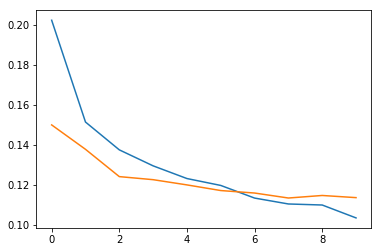

In [100]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

In [101]:
from sklearn.metrics import accuracy_score
h = model2.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 471 test samples: 0.728238


In [59]:
from keras.layers import Input, Dense, GlobalMaxPooling1D, Bidirectional, LSTM
from keras.models import Model


class BaselineModel3(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        print(input_layer.shape)
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            name='Embedding',
                            trainable=False)(input_layer)
        print(embedding_layer.shape)
        drop1 = Dropout(0.5)(embedding_layer)
        bi_lay = Bidirectional(LSTM(200, return_sequences=False))(drop1)
        drop2 = Dropout(0.5)(bi_lay)
        print(drop2.shape)
        f_con = Dense(30, activation="sigmoid")(drop2)
        drop3 = Dropout(0.5)(f_con)
        print(drop3.shape)
        predictions = Dense(3, activation='softmax')(drop3)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [60]:
model3 = BaselineModel3()
model3.compile()

(?, 200)
(?, 200, 100)
(?, ?, 400)
(?, 200, 30)


In [63]:
print(data['train']['text'].shape)

(42371, 200)


In [61]:
#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model3, show_shapes=True).create_png()))

In [62]:
history = model3.fit([data['train']['text'].reshape()],keras.utils.to_categorical(data['train']['y'],3),
                     epochs=10,verbose=0,callbacks=[TQDMNotebookCallback(leave_inner=True,)
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=32
)

ValueError: Error when checking target: expected dense_11 to have 3 dimensions, but got array with shape (42371, 3)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

In [ ]:
from sklearn.metrics import accuracy_score
h = model2.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

In [26]:

import numpy as np
a= np.random.rand(8,6)
b=np.random.rand(3,)
c=np.random.rand(4,1)
#print((a+b).shape) 
print(b)
print(c)
print(a[:2,1:4])

[0.9595083  0.26233734 0.30014796]
[[0.95685904]
 [0.90399242]
 [0.78772734]
 [0.52574663]]
[[0.5834513  0.14647375 0.14317278]
 [0.05805849 0.22996969 0.32466572]]
